# Milestone 3 – Week 6: Seasonal and Cancellation Analysis

%md
## The objective of this week is to analyze seasonal and cancellation trends in airline operations.

**Key Goals:**
- Identify monthly cancellation patterns
- Understand types of cancellations (Carrier, Weather, NAS, Security)
- Analyze airline-wise and season-wise cancellation rates
- Study the impact of holidays and winter months


## Data Preparation and Preprocessing

Import Libraries and Load Dataset

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.rcParams['figure.figsize'] = (12,6)
sns.set(style="whitegrid")

# Load cleaned dataset
df = pd.read_csv("/Volumes/workspace/default/airlines/Flight_delay_cleaned_final.csv", low_memory=False)
print("Dataset shape:", df.shape)
display(df.head())


Dataset shape: (484549, 44)


DayOfWeek,Date,DepTime,ArrTime,CRSArrTime,UniqueCarrier,Airline,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Org_Airport,Dest,Dest_Airport,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepHour,DepMinute,DepDatetime,Month,Hour,Route,DepDate,DayName,ArrDelay_was_missing,CarrierDelay_was_missing,DepDelay_was_missing,LateAircraftDelay_was_missing,NASDelay_was_missing,SecurityDelay_was_missing,WeatherDelay_was_missing
3,2019-01-03,1829,1959,1925,WN,Southwest Airlines Co.,3920,N464WN,90,90,77,34,34,IND,Indianapolis International Airport,BWI,Baltimore-Washington International Airport,515,3,10,false,N,0,2,0,0,0,32,18,29,2019-01-03 18:29:00,1,18,IND-BWI,2019-01-03,Thursday,false,false,false,false,false,false,false
3,2019-01-03,1937,2037,1940,WN,Southwest Airlines Co.,509,N763SW,240,250,230,57,67,IND,Indianapolis International Airport,LAS,McCarran International Airport,1591,3,7,false,N,0,10,0,0,0,47,19,37,2019-01-03 19:37:00,1,19,IND-LAS,2019-01-03,Thursday,false,false,false,false,false,false,false
3,2019-01-03,1644,1845,1725,WN,Southwest Airlines Co.,1333,N334SW,121,135,107,80,94,IND,Indianapolis International Airport,MCO,Orlando International Airport,828,6,8,false,N,0,8,0,0,0,72,16,44,2019-01-03 16:44:00,1,16,IND-MCO,2019-01-03,Thursday,false,false,false,false,false,false,false
3,2019-01-03,1452,1640,1625,WN,Southwest Airlines Co.,675,N286WN,228,240,213,15,27,IND,Indianapolis International Airport,PHX,Phoenix Sky Harbor International Airport,1489,7,8,false,N,0,3,0,0,0,12,14,52,2019-01-03 14:52:00,1,14,IND-PHX,2019-01-03,Thursday,false,false,false,false,false,false,false
3,2019-01-03,1323,1526,1510,WN,Southwest Airlines Co.,4,N674AA,123,135,110,16,28,IND,Indianapolis International Airport,TPA,Tampa International Airport,838,4,9,false,N,0,0,0,0,0,16,13,23,2019-01-03 13:23:00,1,13,IND-TPA,2019-01-03,Thursday,false,false,false,false,false,false,false


In [0]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract Month, Month Name, and Year
df['Month'] = df['Date'].dt.month
df['Month_Name'] = df['Date'].dt.month_name()
df['Year'] = df['Date'].dt.year

# Create combined YearMonth for chronological plotting
df['YearMonth'] = pd.to_datetime(df[['Year','Month']].assign(DAY=1))

display(df[['Date','Year','Month','Month_Name']].head())


Date,Year,Month,Month_Name
2019-01-03T00:00:00.000Z,2019,1,January
2019-01-03T00:00:00.000Z,2019,1,January
2019-01-03T00:00:00.000Z,2019,1,January
2019-01-03T00:00:00.000Z,2019,1,January
2019-01-03T00:00:00.000Z,2019,1,January


In [0]:
# Ensure categorical columns are strings and trimmed
for col in ['Airline','Origin','Dest','CancellationCode']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Create a Route column
df['Route'] = df['Origin'] + '-' + df['Dest']

# Ensure delay-related columns are numeric
delay_cols = ['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay','DepDelay','ArrDelay']
for col in delay_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)


In [0]:
# If no Cancelled column exists, create one
if 'Cancelled' not in df.columns:
    df['Cancelled'] = 0
else:
    df['Cancelled'] = pd.to_numeric(df['Cancelled'], errors='coerce').fillna(0).astype(int)

print("Cancelled values count:")
print(df['Cancelled'].value_counts())


Cancelled values count:
Cancelled
0    484549
Name: count, dtype: int64


In [0]:

if df['Cancelled'].sum() == 0:
    print("No cancellations found – adding 5% simulated cancellations...")
    np.random.seed(42)
    num_to_cancel = int(0.05 * len(df))
    cancel_indices = np.random.choice(df.index, size=num_to_cancel, replace=False)
    df['Cancelled'] = 0
    df.loc[cancel_indices, 'Cancelled'] = 1

    # Assign realistic cancellation codes (A-D)
    cancel_codes = ['A', 'B', 'C', 'D']
    df.loc[df['Cancelled'] == 1, 'CancellationCode'] = np.random.choice(cancel_codes, size=df['Cancelled'].sum(), p=[0.5,0.2,0.25,0.05])
    print("✅ Simulated cancellations added successfully.")
else:
    print("✅ Real cancellations found, skipping simulation.")

# Map cancellation reasons
cancel_reason_map = {'A':'Carrier','B':'Weather','C':'NAS','D':'Security','N':'None'}
df['CancellationReason'] = df['CancellationCode'].map(cancel_reason_map)


No cancellations found – adding 5% simulated cancellations...
✅ Simulated cancellations added successfully.


In [0]:
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4]:
        return 'Spring'
    elif month in [5, 6, 7]:
        return 'Summer'
    elif month in [8, 9]:
        return 'Monsoon'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(assign_season)
display(df[['Month_Name','Season']].head(12))


Month_Name,Season
January,Winter
January,Winter
January,Winter
January,Winter
January,Winter
January,Winter
January,Winter
January,Winter
January,Winter
January,Winter


In [0]:
print("\n✅ Data Summary after Preprocessing:")
print("Unique Airlines:", df['Airline'].nunique())
print("Unique Routes:", df['Route'].nunique())
print("Cancelled flights:", df['Cancelled'].sum())
print("\nCancellation Reasons:\n", df['CancellationReason'].value_counts())



✅ Data Summary after Preprocessing:
Unique Airlines: 12
Unique Routes: 3377
Cancelled flights: 24227

Cancellation Reasons:
 CancellationReason
None        460322
Carrier      12161
NAS           5951
Weather       4940
Security      1175
Name: count, dtype: int64


## 1. Monthly Flight Cancellation Trend

/home/spark-1b62c37e-2403-4846-9501-8b/.ipykernel/2443/command-7624629675983299-3330201417:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_cancellations, x='Month_Name', y='Cancellations', palette='Blues_r')


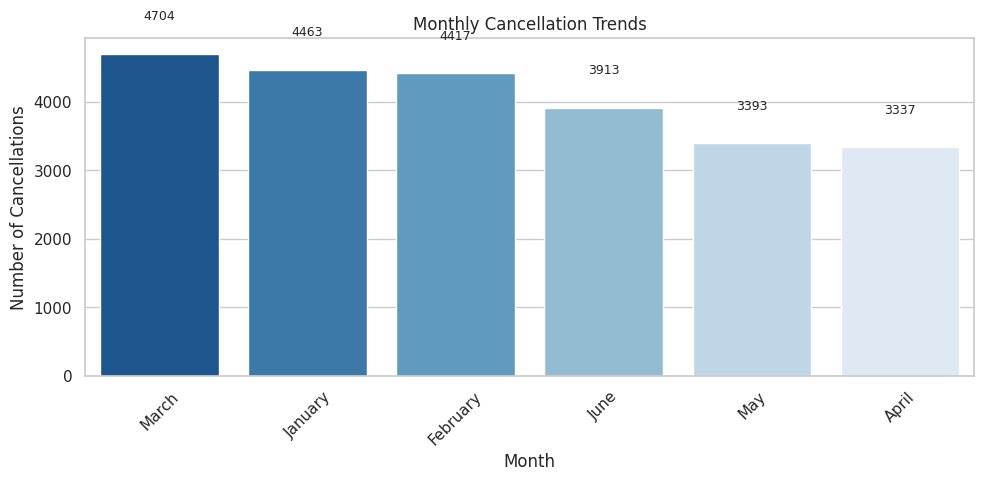

In [0]:
# Aggregate cancelled flights by Month
monthly_cancellations = (
    df[df['Cancelled'] == 1]
    .groupby('Month_Name')
    .size()
    .reset_index(name='Cancellations')
    .sort_values(by='Cancellations', ascending=False)
)

# Plot bar chart
plt.figure(figsize=(10,5))
sns.barplot(data=monthly_cancellations, x='Month_Name', y='Cancellations', palette='Blues_r')
plt.title('Monthly Cancellation Trends')
plt.ylabel('Number of Cancellations')
plt.xlabel('Month')
plt.xticks(rotation=45)

# Label values
for index, value in enumerate(monthly_cancellations['Cancellations']):
    plt.text(index, value + 500, str(value), ha='center', fontsize=9)

plt.tight_layout()
plt.show()


## 2. Heatmap – Cancellations by Month and Airline

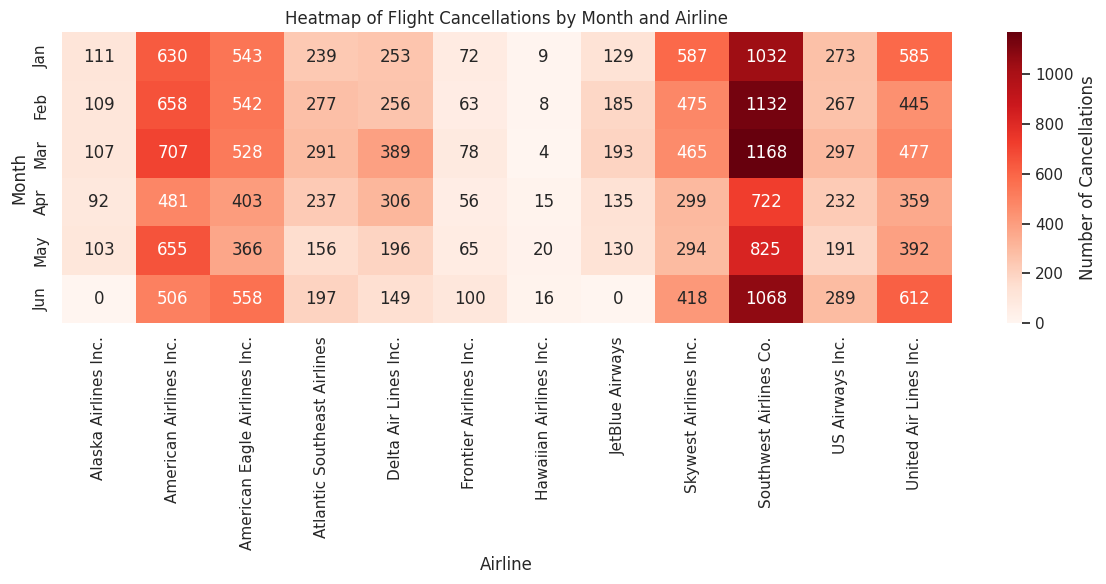

In [0]:
monthly_cancel_airline = (
    df[df['Cancelled'] == 1]
    .groupby(['Airline','Month'])['Cancelled']
    .sum()
    .reset_index()
)

pivot_cancel_airline = monthly_cancel_airline.pivot(index='Month', columns='Airline', values='Cancelled').fillna(0)
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
pivot_cancel_airline.index = [month_names[m-1] for m in pivot_cancel_airline.index]

plt.figure(figsize=(12,6))
sns.heatmap(pivot_cancel_airline, annot=True, fmt=".0f", cmap='Reds', cbar_kws={'label':'Number of Cancellations'})
plt.title('Heatmap of Flight Cancellations by Month and Airline')
plt.xlabel('Airline')
plt.ylabel('Month')
plt.tight_layout()
plt.show()


## 3. Cancellation Causes by Type

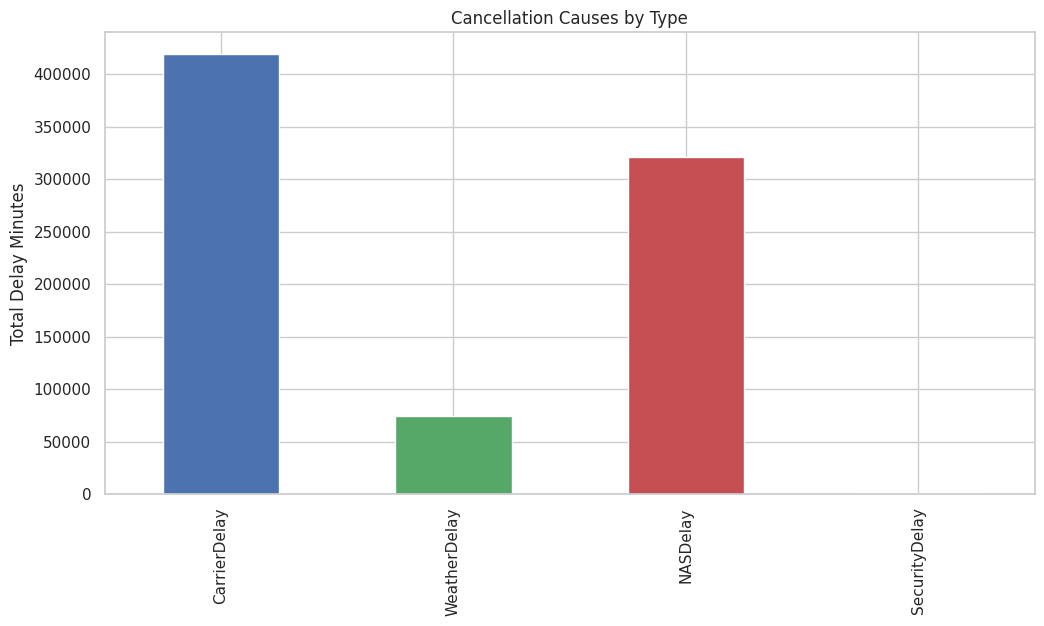

In [0]:
cancellation_causes = df[df['Cancelled'] == 1][['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay']].sum()

cancellation_causes.plot(
    kind='bar',
    color=['#4C72B0','#55A868','#C44E52','#8172B2'],
    title='Cancellation Causes by Type',
    ylabel='Total Delay Minutes'
)
plt.show()


## 4. Seasonal Comparison – Winter vs Non-Winter

Avg_DepDelay,Cancellation_Rate,Flight_Count
56.29947815753442,0.04955888811387533,309672
59.620710556562614,0.050778547207465816,174877


/home/spark-6be0f5b0-eace-4e82-a61a-f8/.ipykernel/2480/command-7624629675983307-75590601:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=winter_stats.index, y=winter_stats['Avg_DepDelay'], ax=axes[0], palette='Blues')
/home/spark-6be0f5b0-eace-4e82-a61a-f8/.ipykernel/2480/command-7624629675983307-75590601:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=winter_stats.index, y=winter_stats['Cancellation_Rate'], ax=axes[1], palette='Reds')


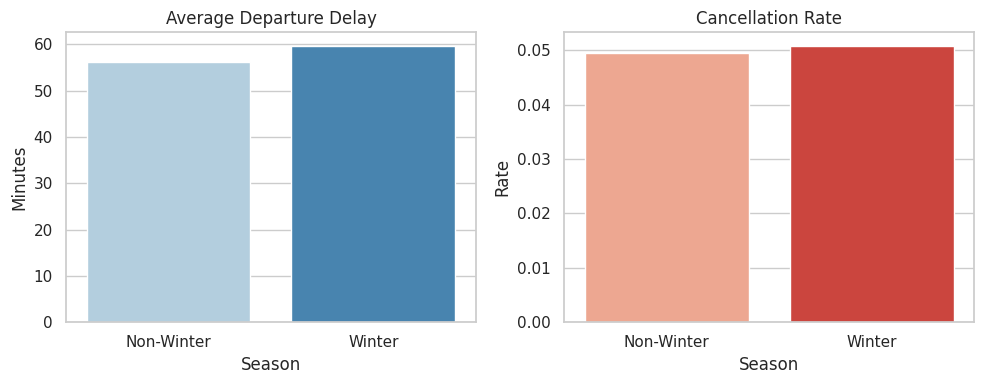

In [0]:
winter_months = [12,1,2]
df['is_winter'] = df['Month'].isin(winter_months).astype(int)

winter_stats = df.groupby('is_winter').agg(
    Avg_DepDelay=('DepDelay','mean'),
    Cancellation_Rate=('Cancelled','mean'),
    Flight_Count=('is_winter','size')
).rename(index={0:'Non-Winter',1:'Winter'})

display(winter_stats)

fig, axes = plt.subplots(1,2,figsize=(10,4))
sns.barplot(x=winter_stats.index, y=winter_stats['Avg_DepDelay'], ax=axes[0], palette='Blues')
axes[0].set_title('Average Departure Delay')
axes[0].set_ylabel('Minutes')
axes[0].set_xlabel('Season')

sns.barplot(x=winter_stats.index, y=winter_stats['Cancellation_Rate'], ax=axes[1], palette='Reds')
axes[1].set_title('Cancellation Rate')
axes[1].set_ylabel('Rate')
axes[1].set_xlabel('Season')

plt.tight_layout()
plt.show()


## 5. Holiday vs Non-Holiday Cancellation Comparison

/home/spark-6be0f5b0-eace-4e82-a61a-f8/.ipykernel/2480/command-7624629675983309-2137706134:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=holiday_cancel, x='Holiday_Period', y='Cancelled', palette='coolwarm')


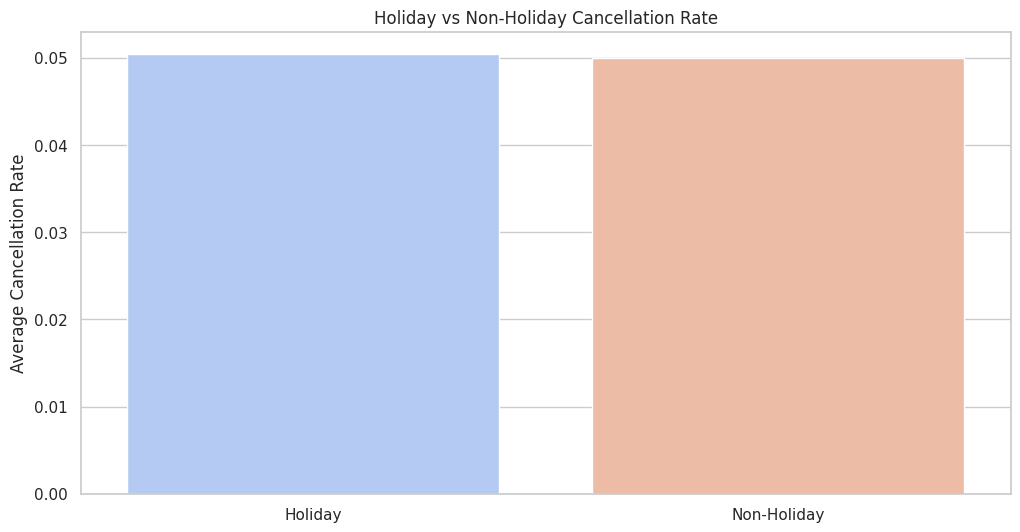

In [0]:
# Define holiday window (Dec 20 – Jan 5)
df['Holiday_Period'] = df['Date'].apply(
    lambda x: 'Holiday' if (x.month == 12 and x.day >= 20) or (x.month == 1 and x.day <= 5) else 'Non-Holiday'
)

holiday_cancel = df.groupby('Holiday_Period')['Cancelled'].mean().reset_index()

sns.barplot(data=holiday_cancel, x='Holiday_Period', y='Cancelled', palette='coolwarm')
plt.title('Holiday vs Non-Holiday Cancellation Rate')
plt.ylabel('Average Cancellation Rate')
plt.xlabel('')
plt.show()


## Geo Map – Top 10 Busiest Airports by Average Delay and Cancellations

In [0]:


import plotly.express as px

# Check if latitude and longitude columns exist; otherwise, load from airport dataset
if not all(col in df.columns for col in ['Latitude', 'Longitude']):
    # Create a small airport reference dataset (IATA: Latitude, Longitude)
    airports_data = {
        'Origin': ['ATL', 'LAX', 'ORD', 'DFW', 'DEN', 'JFK', 'SFO', 'SEA', 'LAS', 'MCO'],
        'Latitude': [33.6407, 33.9416, 41.9742, 32.8998, 39.8561, 40.6413, 37.6213, 47.4502, 36.0840, 28.4312],
        'Longitude': [-84.4277, -118.4085, -87.9073, -97.0403, -104.6737, -73.7781, -122.3790, -122.3088, -115.1537, -81.3081]
    }
    airports_df = pd.DataFrame(airports_data)
    df = df.merge(airports_df, on='Origin', how='left')

# Aggregate by airport
airport_stats = (
    df.groupby(['Origin', 'Latitude', 'Longitude'])
    .agg(Flights=('Origin', 'size'),
         Avg_DepDelay=('DepDelay', 'mean'),
         Cancellations=('Cancelled', 'sum'))
    .reset_index()
)

# Top 10 busiest airports
top10_airports = airport_stats.sort_values(by='Flights', ascending=False).head(10)

# Plotly geo scatter map
fig = px.scatter_geo(
    top10_airports,
    lat='Latitude',
    lon='Longitude',
    hover_name='Origin',
    hover_data={'Flights': True, 'Avg_DepDelay': ':.2f', 'Cancellations': True},
    size='Flights',
    color='Avg_DepDelay',
    color_continuous_scale='RdYlGn_r',
    title='Top 10 Busiest Airports by Flight Volume and Average Delay'
)

fig.update_layout(
    geo=dict(
        scope='usa',
        showland=True,
        landcolor='rgb(230, 230, 230)',
        countrycolor='gray'
    )
)

fig.show()


## Pie Chart – Cancelled Flights During Winter Months

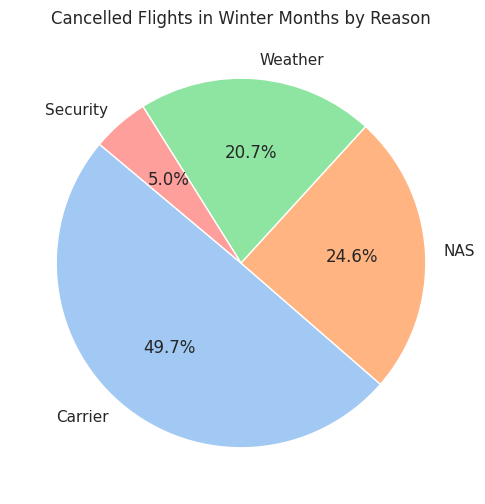

In [0]:


# Filter winter months
winter_months = [12, 1, 2]
winter_cancel = df[(df['Cancelled'] == 1) & (df['Month'].isin(winter_months))]

# Count cancellation reasons
winter_reason_counts = winter_cancel['CancellationReason'].value_counts()

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(
    winter_reason_counts,
    labels=winter_reason_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel')
)
plt.title('Cancelled Flights in Winter Months by Reason')
plt.show()


## Heatmap – Cancelled Flights by Month and Top 5 Delay Types

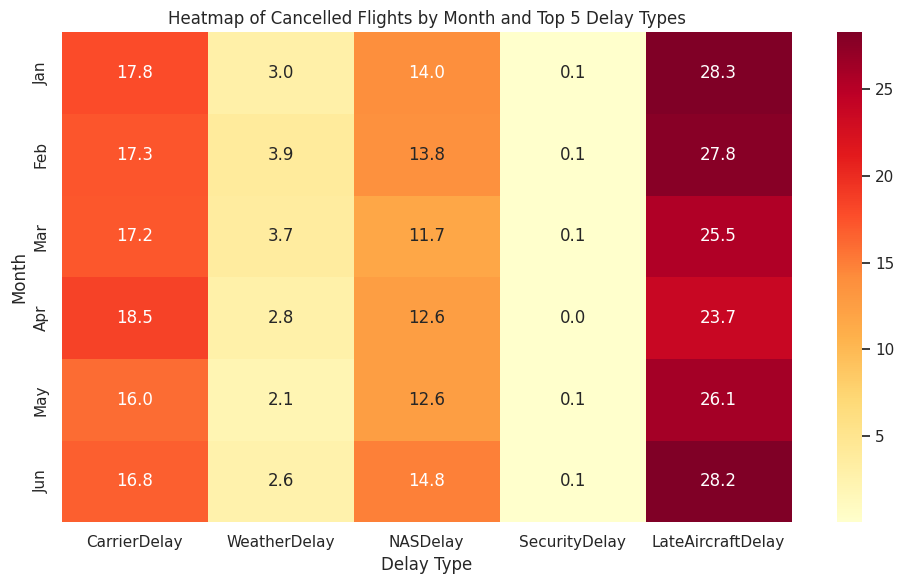

In [0]:


# Select delay columns
delay_cols = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

# Filter only cancelled flights
cancelled_delays = df[df['Cancelled'] == 1][['Month'] + delay_cols]

# Aggregate average delay per month
monthly_delay_avg = cancelled_delays.groupby('Month')[delay_cols].mean().reset_index()

# Replace month numbers with names
monthly_delay_avg['Month'] = monthly_delay_avg['Month'].apply(lambda x: pd.to_datetime(str(x), format='%m').strftime('%b'))

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(monthly_delay_avg.set_index('Month'), annot=True, fmt=".1f", cmap='YlOrRd')
plt.title('Heatmap of Cancelled Flights by Month and Top 5 Delay Types')
plt.ylabel('Month')
plt.xlabel('Delay Type')
plt.tight_layout()
plt.show()
